In [85]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

In [250]:
filepath = 'CIP_2025.xlsx'
data = pd.read_excel(filepath, sheet_name=None)

exchange_rates, forward_rates, interest_rates = data['Spot'].set_index('Date'), data['Forward'].set_index('Date'), data['OIS'].set_index('Date')

cols = ["AUD", "CAD", "CHF", "EUR", "GBP", "JPY", "NZD", "SEK"]
exchange_rates.columns=cols
forward_rates.columns=cols

# The forward df is actually forward points, so we need to make this into forward rates.
forward_rates /= 10000
forward_rates = exchange_rates + forward_rates

interest_rates[['AUD', 'NZD']] /= 100

exchange_rates.columns = [name+"_CURNCY" for name in exchange_rates.columns]
forward_rates.columns = [name+"_CURNCY3M" for name in forward_rates.columns]
interest_rates.columns = [name+"_IR" for name in interest_rates.columns]

In [251]:
#display(exchange_rates.head(), forward_rates.head(), interest_rates.head())

In [252]:
df_merged = (exchange_rates
             .merge(forward_rates, left_index=True, right_index=True, how='inner')
             .merge(interest_rates, left_index=True, right_index=True, how='inner'))

In [259]:
######################################
# 2) Define the currencies (excluding DKK, NOK)
######################################
currencies = ['AUD', 'CAD', 'CHF', 'EUR', 'GBP', 'JPY', 'NZD', 'SEK']

######################################
# 3) Compute the log CIP basis in basis points
#    following STATA's: 
#     cip_i_USD_ln = 100*100 * [ (RF_i/100) 
#                                - (360/90)*(ln(Fut_i_USD) - ln(Spot_i_USD)) 
#                                - (RF_USD/100) ]
######################################
for ccy in currencies:
    fwd_col   = f'{ccy}_CURNCY3M'  # e.g. 'AUD_CURNCY3M'
    spot_col  = f'{ccy}_CURNCY'    # e.g. 'AUD_CURNCY'
    ir_col    = f'{ccy}_IR'        # e.g. 'AUD_IR'
    usd_ir_col = 'USD_IR'
    
    # Skip if any column is missing
    needed = [fwd_col, spot_col, ir_col, usd_ir_col]
    if not all(col in df_merged.columns for col in needed):
        continue
    
    cip_col = f'CIP_{ccy}_ln'
    df_merged[cip_col] = 100*100 * (
        (df_merged[ir_col] / 100.0)
        - (360.0 / 90.0) * (
            np.log(df_merged[fwd_col]) - np.log(df_merged[spot_col])
        )
        - (df_merged[usd_ir_col] / 100.0)
    )

######################################
# 4) Rolling outlier cleanup (45-day window)
#    This emulates STATA's rangestat median & MAD
######################################
window_size = 45
for ccy in currencies:
    cip_col = f'CIP_{ccy}_ln'
    if cip_col not in df_merged.columns:
        continue
    
    # Rolling median over 45 days
    rolling_median = df_merged[cip_col].rolling(window_size).median()
    # Absolute deviation from median
    abs_dev = (df_merged[cip_col] - rolling_median).abs()
    # Rolling mean of abs_dev (i.e. a proxy for MAD)
    rolling_mad = abs_dev.rolling(window_size).mean()
    
    # Mark outliers (abs_dev / mad >= 10)
    outlier_mask = (abs_dev / rolling_mad) >= 10
    df_merged.loc[outlier_mask, cip_col] = np.nan
df_merged = df_merged.loc[:'2019']

array([[<Axes: xlabel='Date'>],
       [<Axes: xlabel='Date'>],
       [<Axes: xlabel='Date'>],
       [<Axes: xlabel='Date'>],
       [<Axes: xlabel='Date'>],
       [<Axes: xlabel='Date'>],
       [<Axes: xlabel='Date'>],
       [<Axes: xlabel='Date'>]], dtype=object)

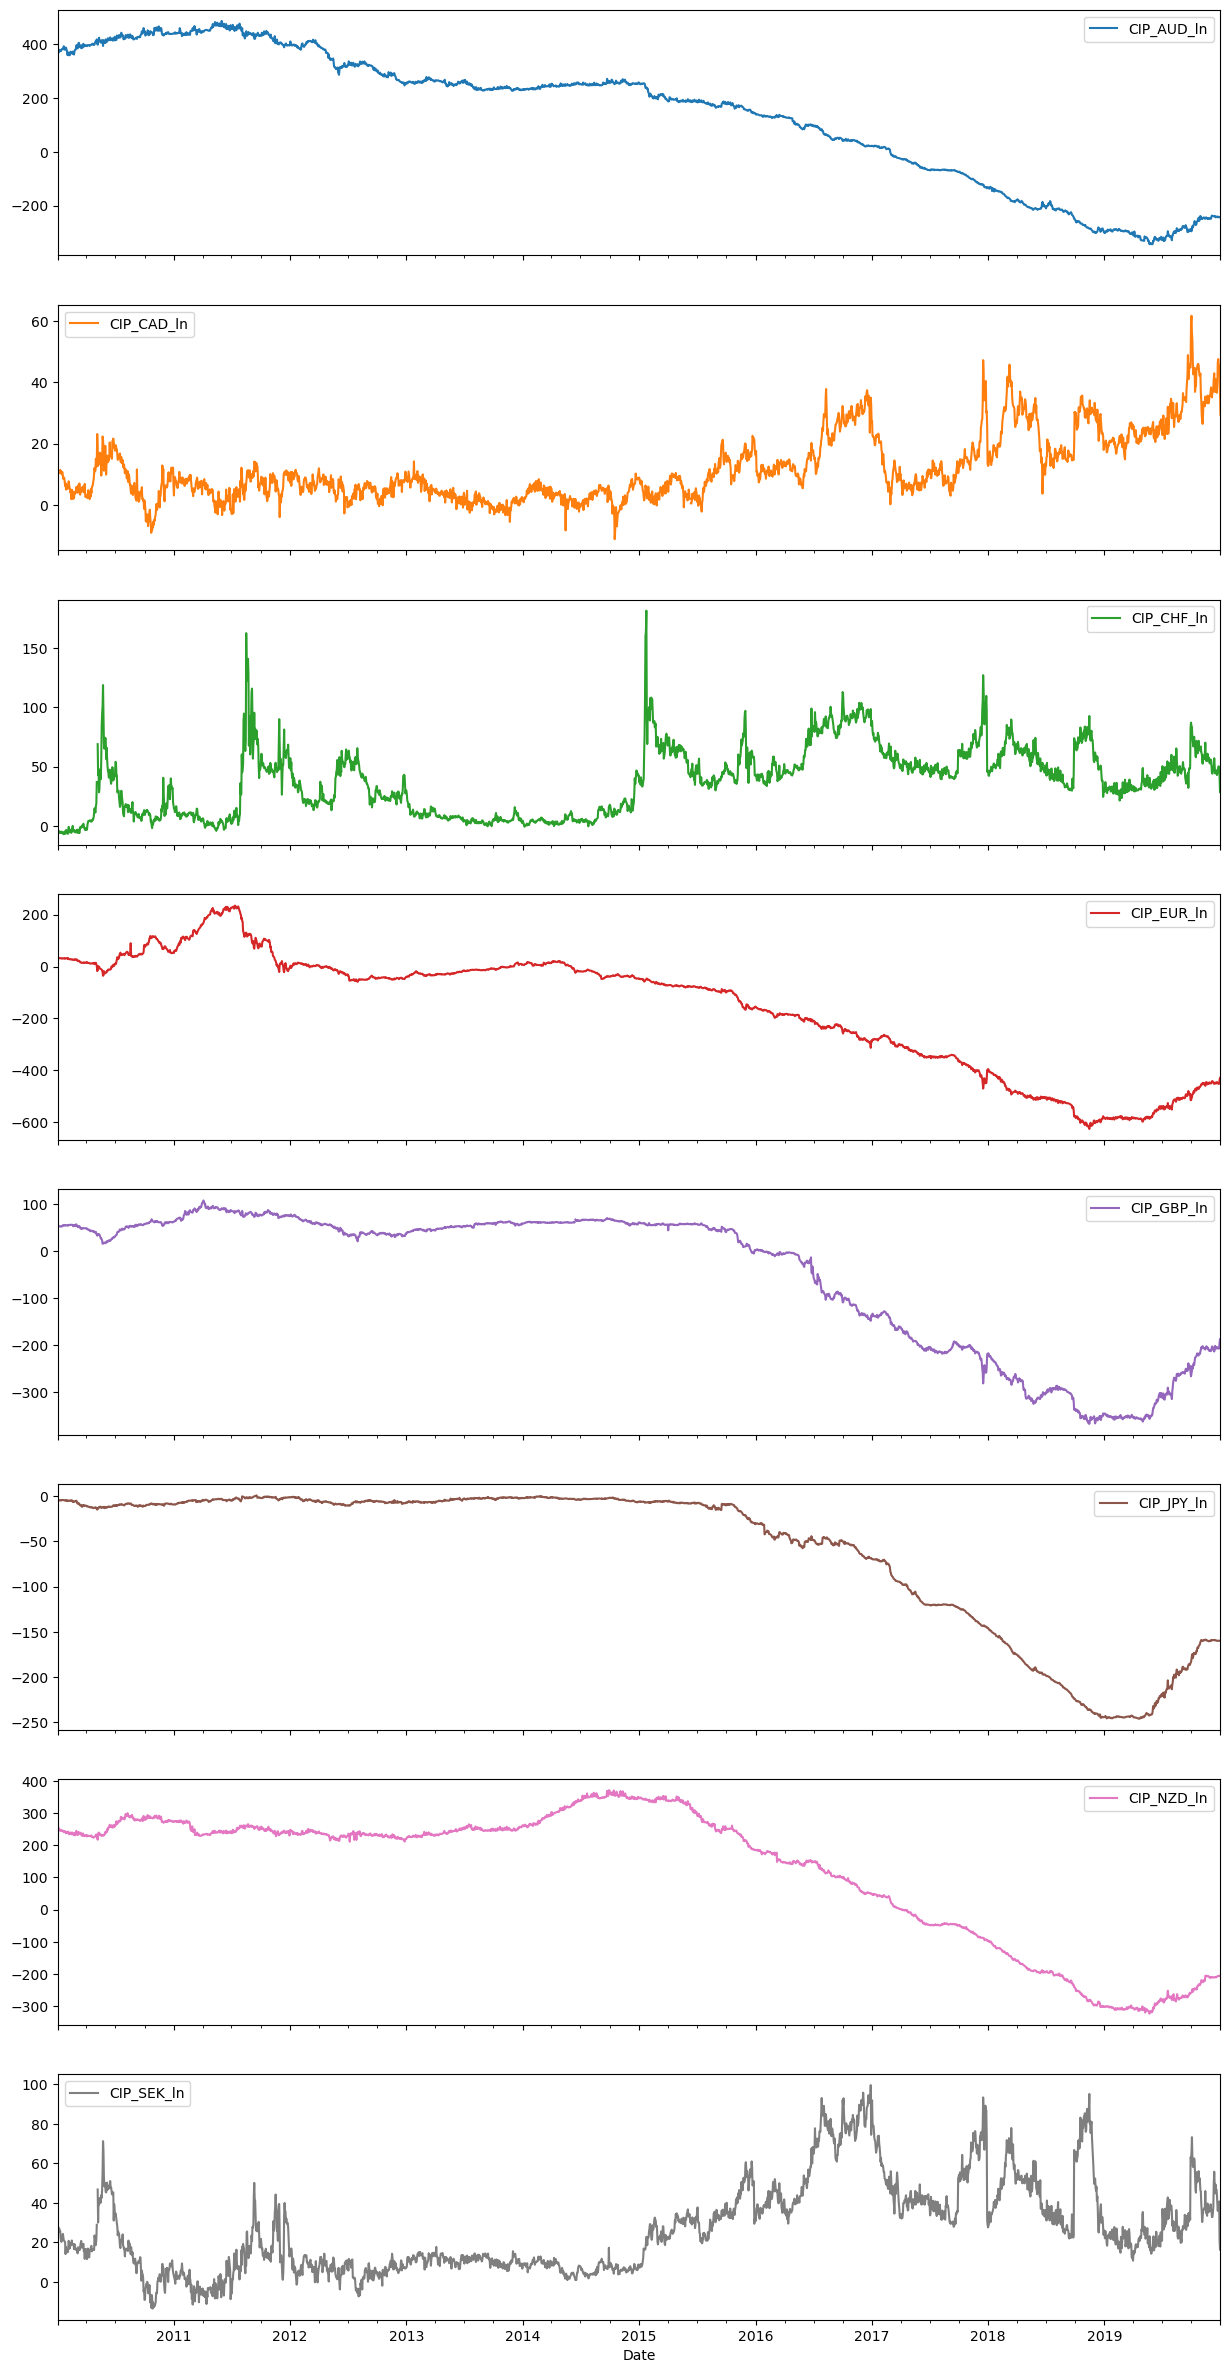

In [260]:
df_merged[[f'CIP_{c}_ln' for c in cols]].plot(subplots=True, layout=(8, 1), figsize=(15, 30), legend=True)